In [1]:
from qiskit import QuantumCircuit

# from qiskit.test import QiskitTestCase
from qiskit.transpiler import CouplingMap, PassManager
from qiskit.transpiler.passes import (
    Unroller,
    TrivialLayout,
    DenseLayout,
    ApplyLayout,
    SabreLayout,
    CountOpsLongestPath,
    Collect1qRuns,
    Collect2qBlocks,
    ConsolidateBlocks,
    SabreSwap,
)
from qiskit.transpiler.passes import OptimizeSwapBeforeMeasure
import numpy as np

from qiskit.transpiler.passes import (
    FullAncillaAllocation,
    EnlargeWithAncilla,
)
from virtual_swap.sqiswap_equiv import sel

from qiskit.transpiler.basepasses import TransformationPass
from qiskit.converters import dag_to_circuit

In [2]:
# this code is buggy, see https://github.com/Qiskit/qiskit-terra/pull/9375
# I can't use this version bc qiskit version missing DAGCircuit functionality
from slam.utils.transpiler_pass.weyl_decompose import RootiSwapWeylDecomposition

In [4]:
# from virtual_swap.vswap_verbose import VirtualSwap as VirtualSwapVerbose
# from virtual_swap.vswap_simple import VirtualSwap as VirtualSwapSimple
from virtual_swap.passes.cns_sa import VSwapPass as VirtualSwap

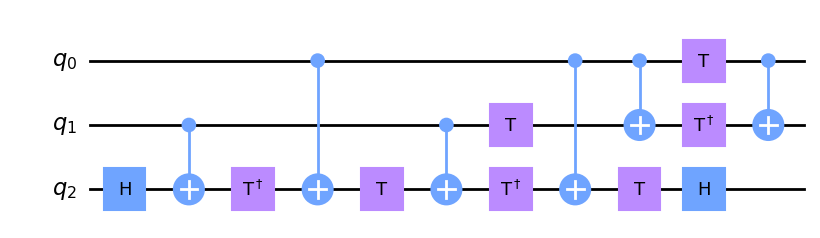

In [13]:
# # build a toffoli
# qc = QuantumCircuit(8)
# qc.ccx(0, 1, 2)
# qc.cx(1, 7)
# qc.ccx(3, 4, 5)
# qc.ccx(2, 5, 6)
# # build a 2x2 square coupling map
# coupling = CouplingMap.from_line(8)

# # build a toffoli
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
linear = CouplingMap.from_line(10)
a2a = CouplingMap.from_full(3)
coupling = linear
qc.decompose().draw("mpl")

In [37]:
# # generate a QFT circuit
# from qiskit.circuit.library import QFT
# # qc = QuantumCircuit(16)
# qc = QFT(8)
# coupling = CouplingMap.from_grid(4,4)

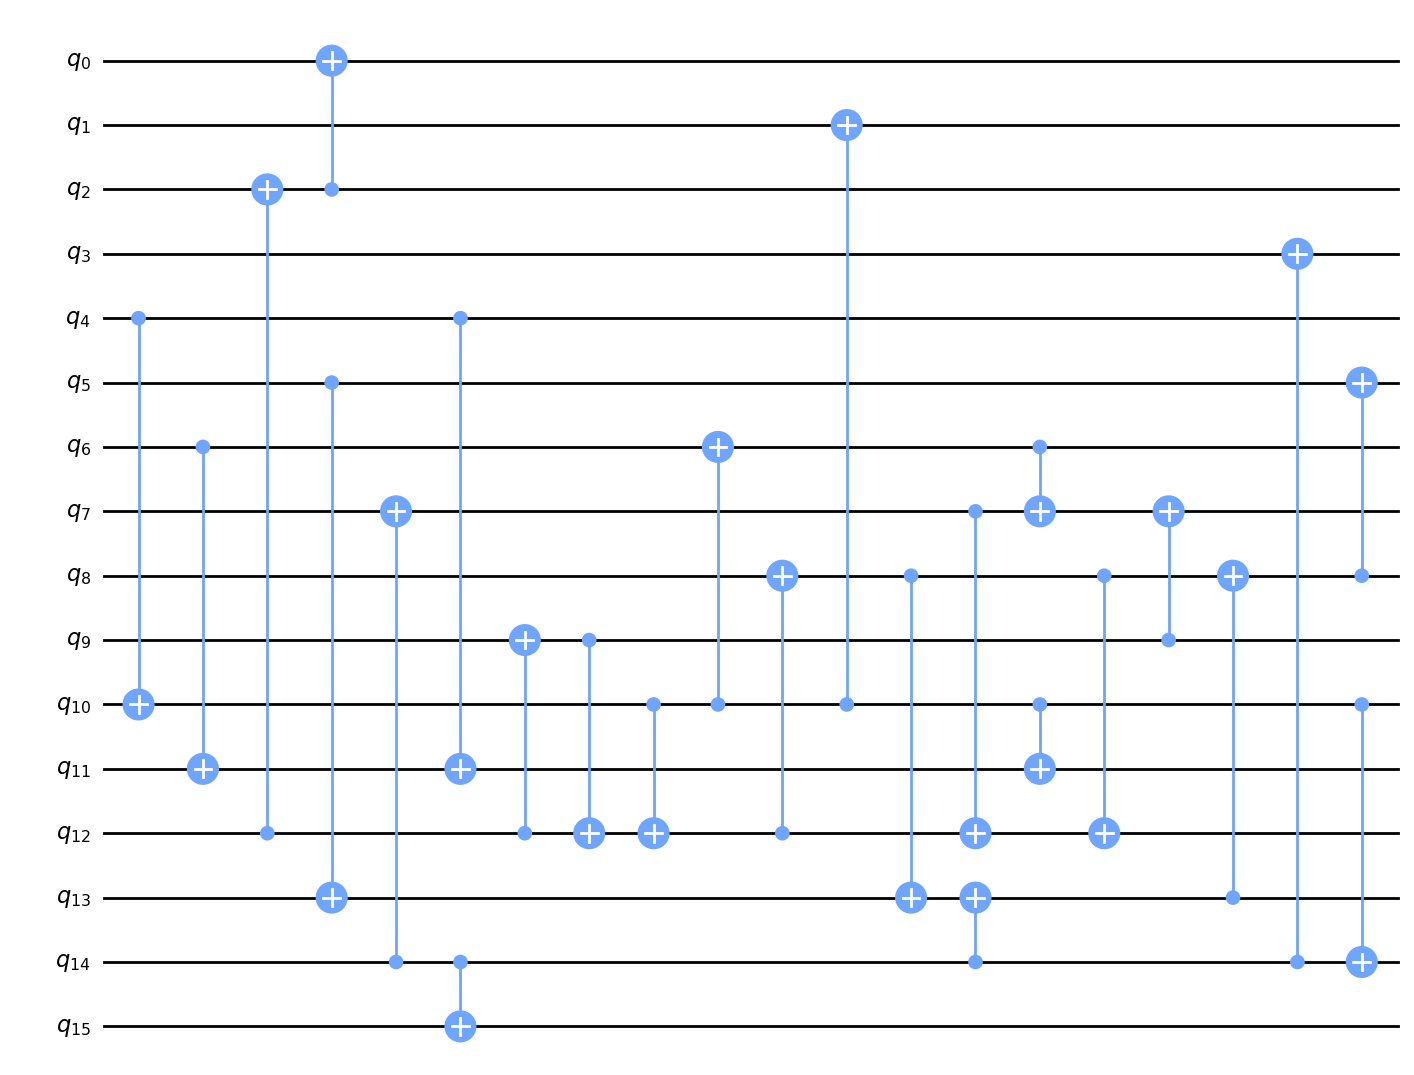

In [49]:
# generate network of random cnots
n, M = 4, 25
N = n**2
qc = QuantumCircuit(N)

for _ in range(M):
    qc.cx(*np.random.choice(N, 2, replace=False))

coupling = CouplingMap.from_grid(n, n)
# coupling = CouplingMap.from_line(N + 1)
# a2a = CouplingMap.from_full(N)
qc.decompose().draw("mpl")

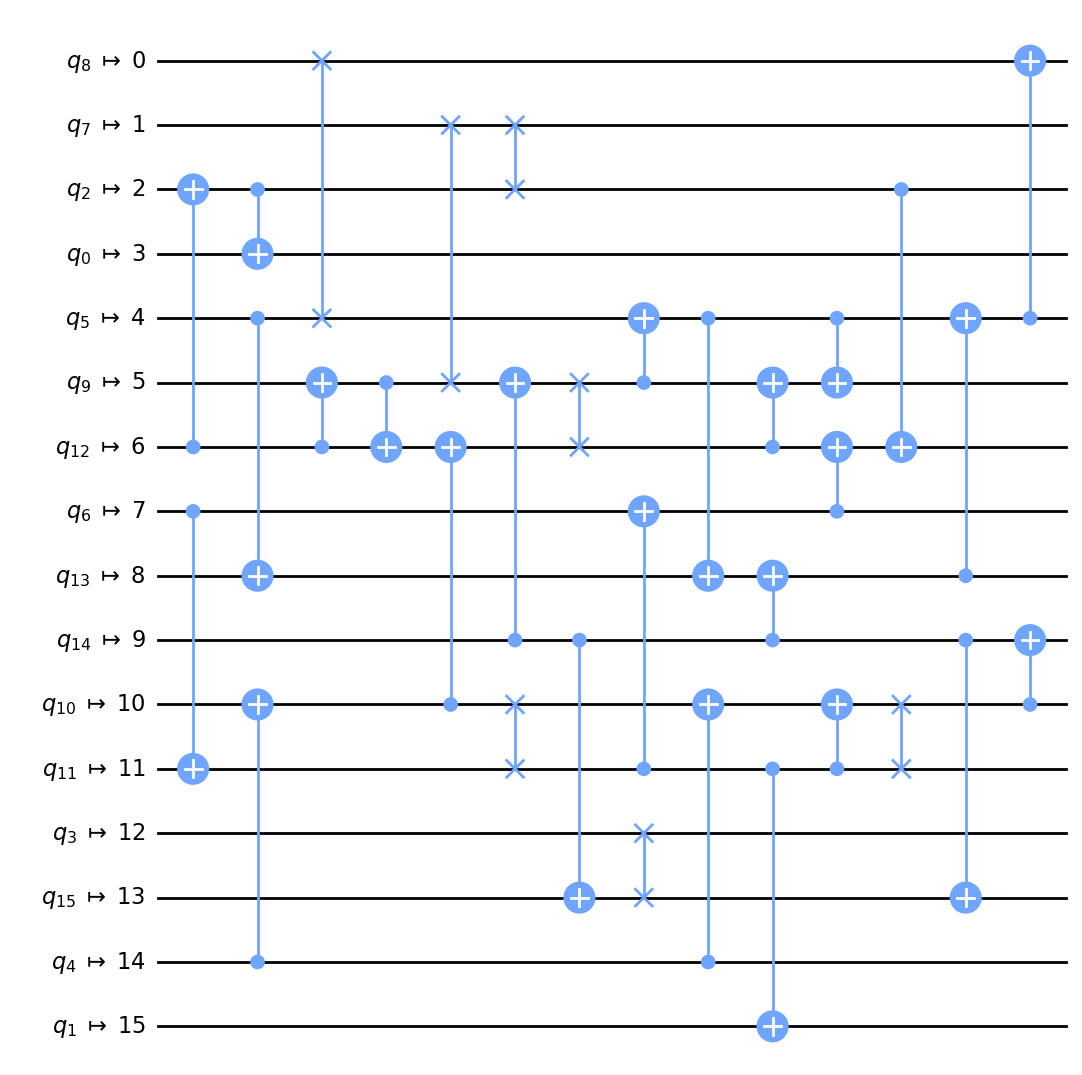

In [60]:
from qiskit import transpile

qc2 = transpile(
    qc,
    coupling_map=coupling,
    basis_gates=["cx", "u3", "swap", "iswap"],
    optimization_level=3,
)
# from virtual_swap.sqiswap_equiv import sel

# qc2 = transpile(
#     qc, coupling_map=coupling, basis_gates=["xx_plus_yy", "u3"], optimization_level=3
# )


# t0_pm = PassManager([Collect2qBlocks(), ConsolidateBlocks(force_consolidate=True)])
# # , RootiSwapWeylDecomposition()])
# t0_pm.append(RootiSwapWeylDecomposition())
# qc3 = t0_pm.run(qc2)

# print(f"Total: {qc3.count_ops().get('riswap', 0)}")
# print(
#     f"Depth: {qc3.depth(filter_function=lambda x: x.operation.name not in ['u3', 'u'])}"
# )

qc2.draw(output="mpl")

Total: 0
Depth: 9


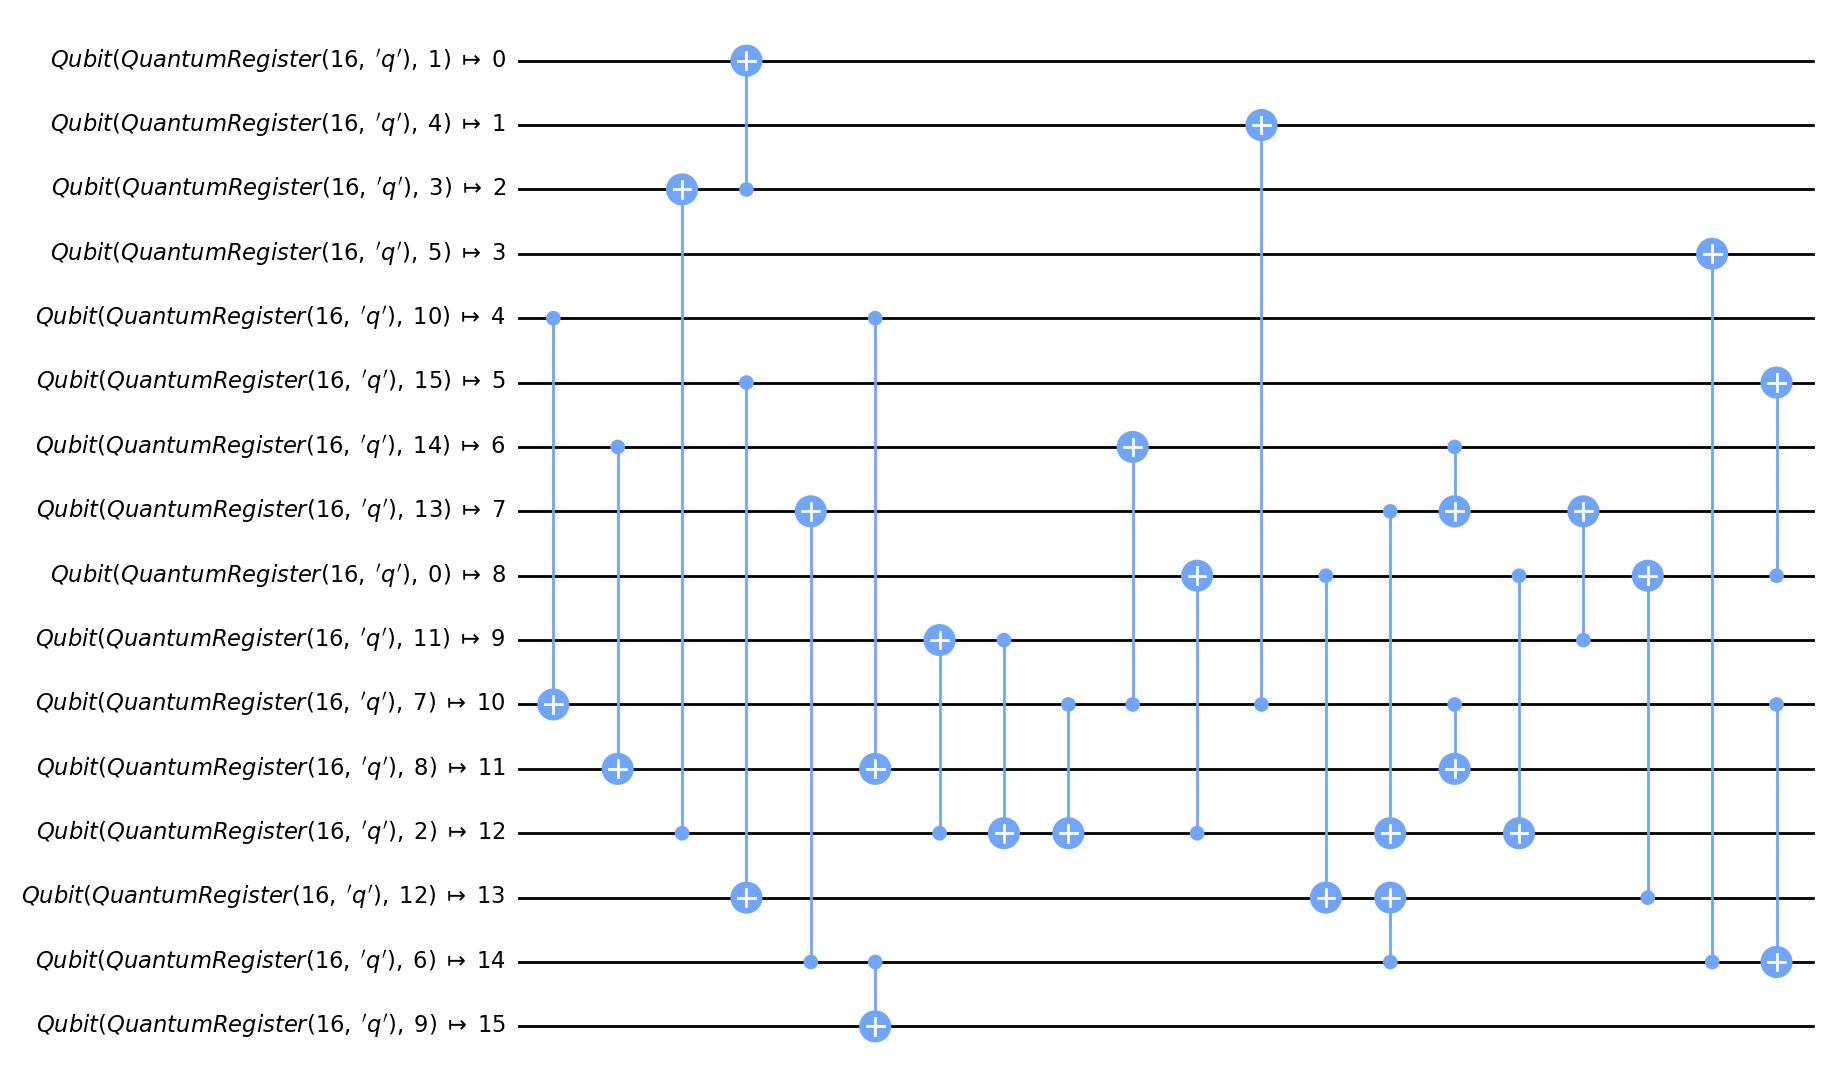

In [57]:
from qiskit import transpile

qc2 = transpile(
    qc,
    coupling_map=coupling,
    basis_gates=["cx", "u3", "swap", "iswap"],
    optimization_level=3,
)
# from virtual_swap.sqiswap_equiv import sel

# qc2 = transpile(
#     qc, coupling_map=coupling, basis_gates=["xx_plus_yy", "u3"], optimization_level=3
# )

# t0_pm = PassManager([Collect2qBlocks(), ConsolidateBlocks(force_consolidate=True)])
# , RootiSwapWeylDecomposition()])
t0_pm = PassManager()
t0_pm.append(
    SabreLayout(coupling, skip_routing=True), Unroller(["u", "cx", "iswap", "swap"])
)
qc3 = t0_pm.run(qc)

print(f"Total: {qc3.count_ops().get('riswap', 0)}")
print(
    f"Depth: {qc3.depth(filter_function=lambda x: x.operation.name not in ['u3', 'u'])}"
)

qc3.draw(output="mpl")

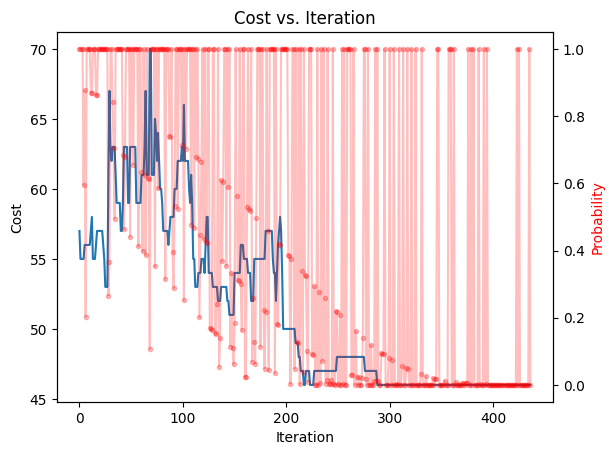

Total: 114
Depth: 58
      ┌───────────────┐                                                       »
 q_0: ┤ U(π/2,-π/2,π) ├─X─────────────────────────────────────────────────────»
      └───────────────┘ │                                                     »
 q_1: ──────────────────X─────────────────────────────────────────────────────»
                                                                              »
 q_2: ────────────────────────────────────────────────────────────────────────»
                                                                              »
 q_3: ────────────────────────────────────────────────────────────────────────»
       ┌─────────────┐                          ┌────────┐     ┌────────────┐ »
 q_4: ─┤ U(0,0,-π/2) ├──────────────────────────┤0       ├─────┤ U(π/2,0,π) ├─»
       └─────────────┘                          │  Iswap │    ┌┴────────────┤ »
 q_5: ────────────────────────────────X─────────┤1       ├────┤ U(0,0,-π/2) ├─»
                   

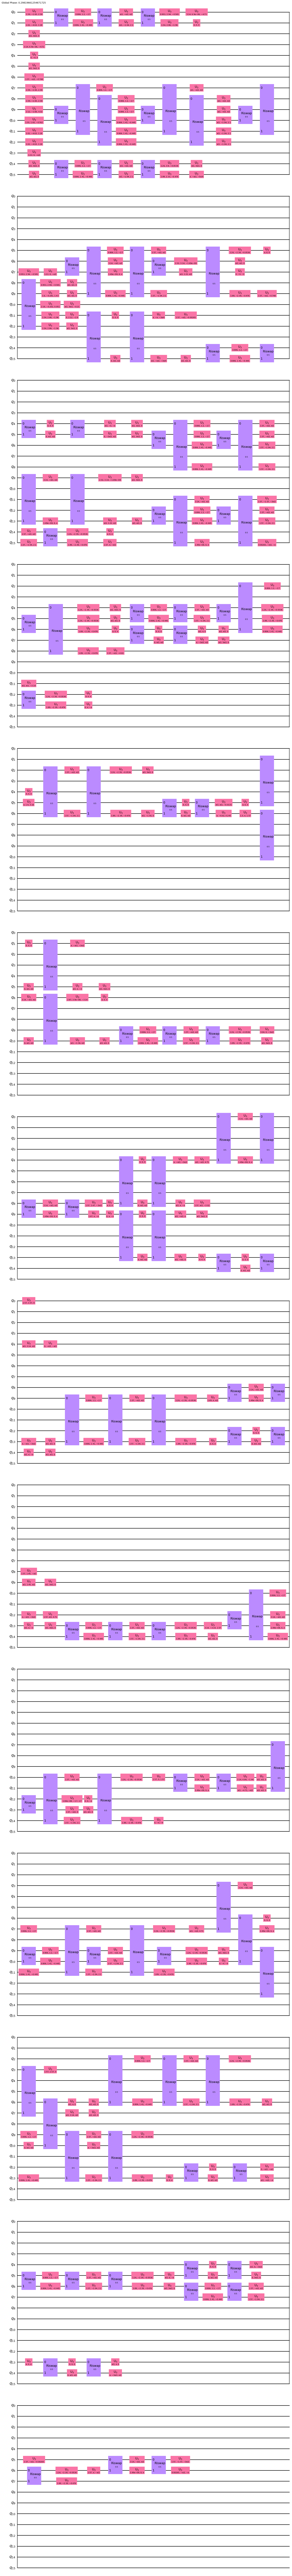

In [58]:
# run the pass
pm = PassManager()

# trivial vs the previously computed layout
# pm.append([TrivialLayout(coupling)])
# pm.append([FullAncillaAllocation(coupling), EnlargeWithAncilla(), ApplyLayout()])

# # XXX
# from qiskit.transpiler.passes import SetLayout
# pm.append(SetLayout(layout=qc2._layout.initial_layout))
pm.property_set = t0_pm.property_set

pm.append(
    VirtualSwap(
        coupling,
        visualize=True,
    )
)
pm.append(SabreSwap(coupling))
pm.append([OptimizeSwapBeforeMeasure()])

pm2 = PassManager()
pm2.append(
    [Collect1qRuns(), Collect2qBlocks(), ConsolidateBlocks(force_consolidate=True)]
)
pm2.append([RootiSwapWeylDecomposition()])
new_circ = pm.run(qc3)
new_circ_decomp = pm2.run(new_circ)

print(f"Total: {new_circ_decomp.count_ops().get('riswap', 0)}")
print(
    f"Depth: {new_circ_decomp.depth(filter_function=lambda x: x.operation.name not in ['u3', 'u'])}"
)
print(new_circ.draw())
new_circ_decomp.draw("mpl")

In [18]:
# qc == qc2 == new_circ_decomp?
# I check with Operator.equiv but false
# idk why

In [19]:
# # XXPlusYYGate(np.pi/2) equiv to riswap(0.5)?
# from slam.utils.gates.custom_gates import RiSwapGate
# from qiskit.quantum_info import Operator
# from qiskit.circuit.library import XXPlusYYGate

# Operator(XXPlusYYGate(-np.pi / 2)).equiv(RiSwapGate(0.5))

In [20]:
# from qiskit.circuit.library import XXPlusYYGate, SwapGate, CXGate
# from qiskit.quantum_info import Operator

# cx_decomp = QuantumCircuit(2)
# cx_decomp.u(np.pi / 4, 0, np.pi / 2, 0)
# cx_decomp.u(np.pi / 4, 0, np.pi / 2, 1)
# cx_decomp.append(XXPlusYYGate(-np.pi / 2, 0), [0, 1])
# cx_decomp.u(np.pi / 4, 0, np.pi / 2, 0)
# cx_decomp.u(np.pi / 4, 0, np.pi / 2, 1)
# cx_decomp.append(XXPlusYYGate(-np.pi / 2), [0, 1])
# cx_decomp.u(np.pi / 4, 0, np.pi / 2, 0)
# cx_decomp.u(np.pi / 4, 0, np.pi / 2, 1)
# # sel.add_equivalence(CXGate(), cx_decomp)
# assert Operator(CXGate()).equiv(Operator(cx_decomp))

# swap_decomp = QuantumCircuit(2)
# swap_decomp.u(np.pi / 4, 0, np.pi / 2, 0)
# swap_decomp.u(np.pi / 4, 0, np.pi / 2, 1)
# swap_decomp.append(XXPlusYYGate(-np.pi / 2, 0), [0, 1])
# swap_decomp.u(np.pi / 4, 0, np.pi / 2, 0)
# swap_decomp.u(np.pi / 4, 0, np.pi / 2, 1)
# swap_decomp.append(XXPlusYYGate(-np.pi / 2), [0, 1])
# swap_decomp.u(np.pi / 4, 0, np.pi / 2, 0)
# swap_decomp.u(np.pi / 4, 0, np.pi / 2, 1)
# swap_decomp.append(XXPlusYYGate(-np.pi / 2), [0, 1])
# swap_decomp.u(np.pi / 4, 0, np.pi / 2, 0)
# swap_decomp.u(np.pi / 4, 0, np.pi / 2, 1)
# # sel.add_equivalence(SwapGate(), swap_decomp)
# assert Operator(SwapGate()).equiv(Operator(swap_decomp))